In [ ]:
%%writefile utils.py
import numpy as np
import pandas as pd
import tensorflow
from matplotlib import pyplot as plt
import seaborn as sns
import os

bs = 16


def norm_data(x):
    data = (x - stats['mean']) / stats['std']
    data = data.fillna(0)
    return data

def format_output(data):
    fan = np.array(data['Kipas'].copy())
    humid = np.array(data['Humidifier'].copy())
    led = np.array(data['LED'].copy())
    s_tanah = np.array(data['Selenoid_tanah'].copy())
    selenoid = np.array(data['Selenoid'].copy())

    features = data.drop(['Kipas', 'Humidifier', 'LED', 'Selenoid_tanah', 'Selenoid'], axis=1)

    return features, (fan, humid, led, s_tanah, selenoid)


def print_model(model, tf: tensorflow):
    return tf.keras.utils.plot_model(model, show_shapes=True)


def show_image_samples(generated_data, classes):
    class_indices = generated_data.class_indices
    class_ = list(class_indices.keys())
    imgs, labels = generated_data.next()
    plt.figure(figsize=(20, 20))
    length = len(labels)
    r = length if length < 25 else 25

    for i in range(r):
        plt.subplot(5, 5, i + 1)
        plt.imshow(imgs[i], cmap='gray')
        idx = int(labels[i])
        c_name = classes[idx]
        plt.title(c_name, color='Blue', fontsize=16)
        plt.axis('off')
    plt.show()


def plot_confusion_matrix(cm, title, labels=[0, 1], ax=None):
    if ax is None:
        ax = plt.gca()
    sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', ax=ax)
    ax.set_title(title, pad=20, fontsize=20, fontweight="bold")
    ax.set_ylabel('Actual')
    ax.set_xlabel('Predicted')

Writing utils.py


In [ ]:
# Download the CUDA 11.8 pin and move it to the preferences directory
!wget https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64/cuda-ubuntu1804.pin
!sudo mv cuda-ubuntu1804.pin /etc/apt/preferences.d/cuda-repository-pin-600

# Download the CUDA 11.8 local installer
!wget https://developer.download.nvidia.com/compute/cuda/11.8.0/local_installers/cuda-repo-ubuntu1804-11-8-local_11.8.0-520.61.05-1_amd64.deb

# Install the CUDA 11.8 package
!sudo dpkg -i cuda-repo-ubuntu1804-11-8-local_11.8.0-520.61.05-1_amd64.deb
!sudo cp /var/cuda-repo-ubuntu1804-11-8-local/cuda-*-keyring.gpg /usr/share/keyrings/

# Update the package lists
!sudo apt-get update

# Install CUDA 11.8
!sudo apt-get install -y cuda-toolkit-11-8

# Set environment variables for CUDA 11.8
!echo 'export PATH=/usr/local/cuda-11.8/bin${PATH:+:${PATH}}' >> ~/.bashrc
!echo 'export LD_LIBRARY_PATH=/usr/local/cuda-11.8/lib64${LD_LIBRARY_PATH:+:${LD_LIBRARY_PATH}}' >> ~/.bashrc
!source ~/.bashrc

# Verify CUDA installation
!nvcc --version

# Download and install cuDNN 8.6
!wget https://developer.download.nvidia.com/compute/redist/cudnn/v8.6.0/cudnn-11.8-linux-x64-v8.6.0.163.tgz

# Extract and copy cuDNN files to the CUDA directory
!tar -xzvf cudnn-11.8-linux-x64-v8.6.0.163.tgz
!sudo cp cuda/include/cudnn*.h /usr/local/cuda-11.8/include
!sudo cp -P cuda/lib64/libcudnn* /usr/local/cuda-11.8/lib64
!sudo chmod a+r /usr/local/cuda-11.8/include/cudnn*.h /usr/local/cuda-11.8/lib64/libcudnn*

# Verify cuDNN installation
!cat /usr/local/cuda-11.8/include/cudnn_version.h | grep CUDNN_MAJOR -A 2

!pip install tensorflow-gpu==2.10.*

--2025-01-12 09:35:48--  https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64/cuda-ubuntu1804.pin
Resolving developer.download.nvidia.com (developer.download.nvidia.com)... 23.58.144.143, 23.58.144.150, 23.58.144.132
Connecting to developer.download.nvidia.com (developer.download.nvidia.com)|23.58.144.143|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 190 [text/plain]
Saving to: ‘cuda-ubuntu1804.pin’

cuda-ubuntu1804.pin 100%[===================>]     190  --.-KB/s    in 0s      

2025-01-12 09:35:48 (127 MB/s) - ‘cuda-ubuntu1804.pin’ saved [190/190]

--2025-01-12 09:35:49--  https://developer.download.nvidia.com/compute/cuda/11.8.0/local_installers/cuda-repo-ubuntu1804-11-8-local_11.8.0-520.61.05-1_amd64.deb
Resolving developer.download.nvidia.com (developer.download.nvidia.com)... 23.58.144.143, 23.58.144.150, 23.58.144.132
Connecting to developer.download.nvidia.com (developer.download.nvidia.com)|23.58.144.143|:443... connected.
HTTP

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!mkdir ~/.kaggle
!cp /content/drive/MyDrive/kaggle.json ~/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d 'paddy-time-series-and-sensor-balanced'
!mkdir /content/dataset
!unzip -q paddy-time-series-and-sensor-balanced.zip -d /content/dataset/

Dataset URL: https://www.kaggle.com/datasets/bintangpratomo/paddy-time-series-and-sensor-balanced
License(s): unknown
100% 234M/235M [00:14<00:00, 20.1MB/s]
100% 235M/235M [00:14<00:00, 17.3MB/s]


In [ ]:
from tensorflow.keras.layers import *
import tensorflow as tf
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import plotly.express as px


In [ ]:
print(tf.__version__)
print(tf.config.list_physical_devices('GPU'))

2.10.1
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## Preparing Num Data

In [ ]:
data = pd.read_excel('/content/dataset/combined_dataset.xlsx')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8866 entries, 0 to 8865
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   datetime        8866 non-null   object 
 1   Temperature     8866 non-null   float64
 2   Humidity        8866 non-null   int64  
 3   Illumination    8866 non-null   float64
 4   Kipas           8866 non-null   int64  
 5   Humidifier      8866 non-null   int64  
 6   LED             8866 non-null   int64  
 7   PhTanah         8866 non-null   float64
 8   Selenoid_tanah  8866 non-null   object 
 9   Water_Level     8866 non-null   float64
 10  Selenoid        8866 non-null   object 
dtypes: float64(4), int64(4), object(3)
memory usage: 762.0+ KB


In [ ]:
device_columns = ['Kipas', 'Humidifier', 'LED', 'Selenoid_tanah', 'Selenoid']

figs = []

for device in device_columns:
    device_counts = data[device].value_counts().reset_index()
    device_counts.columns = [device, 'Count']

    fig = px.bar(device_counts, x=device, y='Count',
                 title=f'Distribution of {device} Types',
                 labels={device: 'Device Type', 'Count': 'Count'})
    figs.append(fig)

figs[0].update_layout(
    xaxis_title='Device Type',
    yaxis_title='Count',
    title='Distribution of Device Types'
)

from plotly.subplots import make_subplots
from plotly.graph_objs import Bar

subplot_fig = make_subplots(
    rows=1, cols=5,
    shared_yaxes=True,
    subplot_titles=[f"Distribution of {device}" for device in device_columns]
)

for i, device in enumerate(device_columns):
    device_counts = data[device].value_counts().reset_index()
    device_counts.columns = [device, 'Count']

    trace = Bar(x=device_counts[device], y=device_counts['Count'], name=device)

    subplot_fig.add_trace(trace, row=1, col=i+1)

subplot_fig.update_layout(
    height=600,
    width=1800,
    title_text="Distribution of Device Types",
    showlegend=False
)

subplot_fig.show()


In [ ]:
data = data.drop('datetime', axis=1)
mapper = {'OFF': 0, 'ON': 1}
data['Selenoid_tanah'] = data['Selenoid_tanah'].map(mapper)
data['Selenoid'] = data['Selenoid'].map(mapper)
data = data.fillna(0)

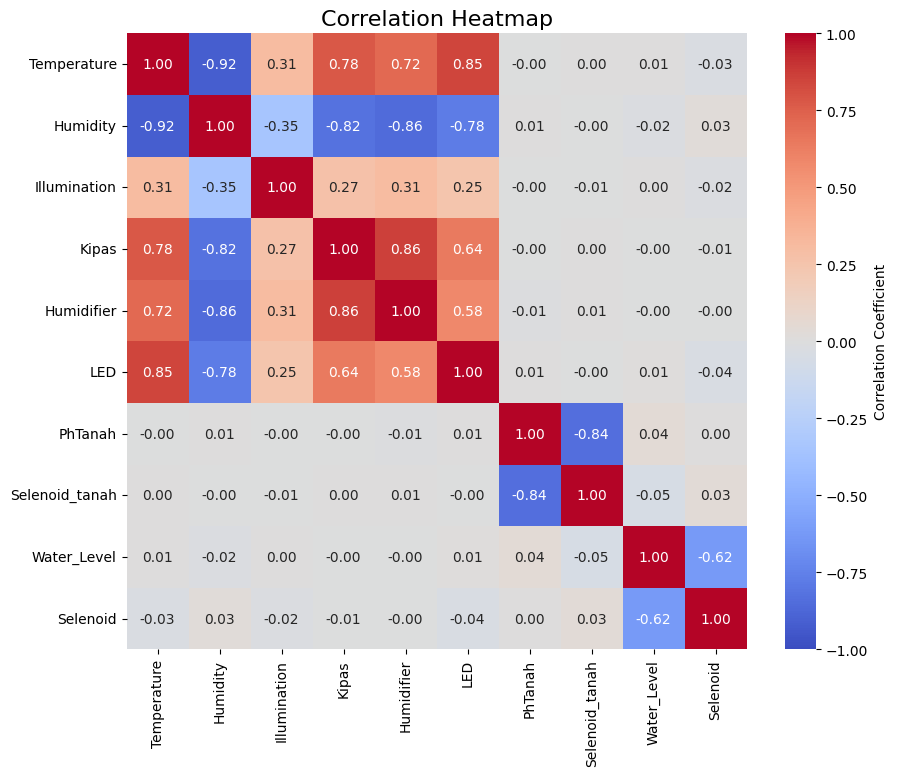

In [ ]:
corr_matrix = data.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', vmin=-1, vmax=1, cbar_kws={'label': 'Correlation Coefficient'})

plt.title('Correlation Heatmap', fontsize=16)
plt.show()


In [ ]:
stats = data.describe()
stats.pop('Kipas')
stats.pop('LED')
stats.pop('Humidifier')
stats.pop('Selenoid')
stats.pop('Selenoid_tanah')
stats = stats.transpose()
stats

,count,mean,std,min,25%,50%,75%,max
Temperature,8866.0,29.948850,1.032873,27.60,28.90,30.20,30.800,32.80
Humidity,8866.0,66.783555,4.345455,54.00,64.00,67.00,70.000,76.00
Illumination,8866.0,73.429239,1.497201,69.60,72.82,73.24,73.650,80.59
PhTanah,8866.0,5.062856,1.196045,1.37,4.08,5.16,6.155,7.00
Water_Level,8866.0,338.111474,26.303731,225.00,325.00,336.00,342.000,482.00


In [ ]:
train, temp = train_test_split(data, test_size=0.4, random_state=1, shuffle=False)
val, test = train_test_split(temp, test_size=0.5, random_state=1, shuffle=False)

In [ ]:
del temp

In [ ]:
def norm_data(x):
    data = (x - stats['mean']) / stats['std']
    data = data.fillna(0)
    return data

def format_output(data):
    fan = np.array(data['Kipas'].copy())
    humid = np.array(data['Humidifier'].copy())
    led = np.array(data['LED'].copy())
    s_tanah = np.array(data['Selenoid_tanah'].copy())
    selenoid = np.array(data['Selenoid'].copy())

    features = data.drop(['Kipas', 'Humidifier', 'LED', 'Selenoid_tanah', 'Selenoid'], axis=1)

    return features, (fan, humid, led, s_tanah, selenoid)

In [ ]:
train, (y_train_fan, y_train_humid, y_train_led, y_train_tanah, y_train_selenoid) = format_output(train)
val, (y_val_fan, y_val_humid, y_val_led, y_val_tanah, y_val_selenoid) = format_output(val)
test, (y_test_fan, y_test_humid, y_test_led, y_test_tanah, y_test_selenoid) = format_output(test)

## Preparing Image Data

In [ ]:
img_path = '/content/dataset/paddy_balance_v2'
bs = 32

In [ ]:
import os
classes = [x for x in os.listdir(img_path) if os.path.isdir(os.path.join(img_path, x))]
classes.sort()
classes

['day 1', 'day 2', 'day 3', 'day 4', 'day 5', 'day 6', 'day 7', 'day 8']

In [ ]:
data_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1/255.,
    validation_split=.4,
)

test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1/255.,
    validation_split=.2)

In [ ]:
train_data = data_generator.flow_from_directory(
    img_path,
    target_size=(224, 224),
    batch_size=bs,
    color_mode='rgb',
    classes=classes,
    class_mode='sparse',
    subset='training',
    shuffle=True
)

data_val = test_generator.flow_from_directory(
    img_path,
    target_size=(224, 224),
    batch_size=bs,
    color_mode='rgb',
    classes=classes,
    class_mode='sparse',
    subset='validation',
    shuffle=True
)

data_test = test_generator.flow_from_directory(
    img_path,
    target_size=(224, 224),
    batch_size=bs,
    color_mode='rgb',
    classes=classes,
    class_mode='sparse',
    subset='validation',
    shuffle=False
)

Found 5323 images belonging to 8 classes.
Found 1770 images belonging to 8 classes.
Found 1770 images belonging to 8 classes.


In [ ]:
import numpy as np

def unpack_data(data_generator, batch_size):
    """
    Unpacks all images and labels from a data generator (e.g., train, validation, or test).

    Parameters:
    - data_generator: The generator (e.g., train_data, data_val, data_test) to unpack.
    - batch_size: The batch size used in the generator.

    Returns:
    - images: All images in the dataset (NumPy array).
    - labels: All labels in the dataset (NumPy array).
    """
    images = []
    labels = []

    # Iterate through the generator and collect batches
    for images_batch, labels_batch in data_generator:
        images.append(images_batch)
        labels.append(labels_batch)

        # Break if we've processed all images
        if len(images) * batch_size >= len(data_generator.filenames):
            break

    # Concatenate all the batches into single arrays
    images = np.concatenate(images, axis=0)
    labels = np.concatenate(labels, axis=0)

    return images, labels

train_images, train_labels = unpack_data(train_data, bs)
val_images, val_labels = unpack_data(data_val, bs)
test_images, test_labels = unpack_data(data_test, bs)


In [ ]:
def img_base_model(inputs):
    base_model = tf.keras.applications.VGG19(include_top=False, weights='imagenet', input_tensor=inputs)
    for layer in base_model.layers:
        layer.trainable = False
    x = base_model(inputs)
    x = Flatten()(x)
    x = BatchNormalization()(x)
    return x

In [ ]:
input1 = Input(shape=(3,), name='input_temp_humid_ilum')
input2 = Input(shape=(1,), name="input_selenoid_soil")
input3 = Input(shape=(1,), name="input_selenoid_water")
input4 = Input(shape=(224, 224, 3), name='input_image')

x = Reshape((3, 1))(input1)
x = Conv1D(filters=64, kernel_size=1, activation='relu', padding='same')(x)
x = LSTM(64, return_sequences=True)(x)
x = LSTM(32, return_sequences=False)(x)

x2 = Reshape((1, 1))(input2)
x2 = Lambda(lambda x: tf.repeat(x, repeats=3, axis=-1))(x2)
x2 = Conv1D(filters=64, kernel_size=1, activation='relu', padding='same')(x2)
x2 = LSTM(64, return_sequences=True)(x2)
x2 = LSTM(32, return_sequences=False)(x2)

x3 = Reshape((1, 1))(input3)
x3 = Lambda(lambda x: tf.repeat(x, repeats=3, axis=-1))(x3)
x3 = Conv1D(filters=64, kernel_size=1, activation='relu', padding='same')(x3)
x3 = LSTM(64, return_sequences=True)(x3)
x3 = LSTM(32, return_sequences=False)(x3)

x4 = img_base_model(input4)
x4 = Dense(512, activation='relu')(x4)
x4 = Dense(512, activation='relu')(x4)


output_fan = Dense(1, activation='sigmoid', name='output_fan')(x)
output_humid = Dense(1, activation='sigmoid', name='output_humid')(x)
output_led = Dense(1, activation='sigmoid', name='output_led')(x)
output_tanah = Dense(1, activation='sigmoid', name='output_tanah')(x2)
output_selenoid = Dense(1, activation='sigmoid', name='output_selenoid')(x3)
output_img = Dense(len(classes), activation='softmax', name='output_img')(x4)

80134624/80134624 [==============================] - 4s 0us/step


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_selenoid_soil (InputLaye  [(None, 1)]         0           []                               
 r)                                                                                               
                                                                                                  
 input_selenoid_water (InputLay  [(None, 1)]         0           []                               
 er)                                                                                              
                                                                                                  
 input_image (InputLayer)       [(None, 224, 224, 3  0           []                               
                                )]                                                            

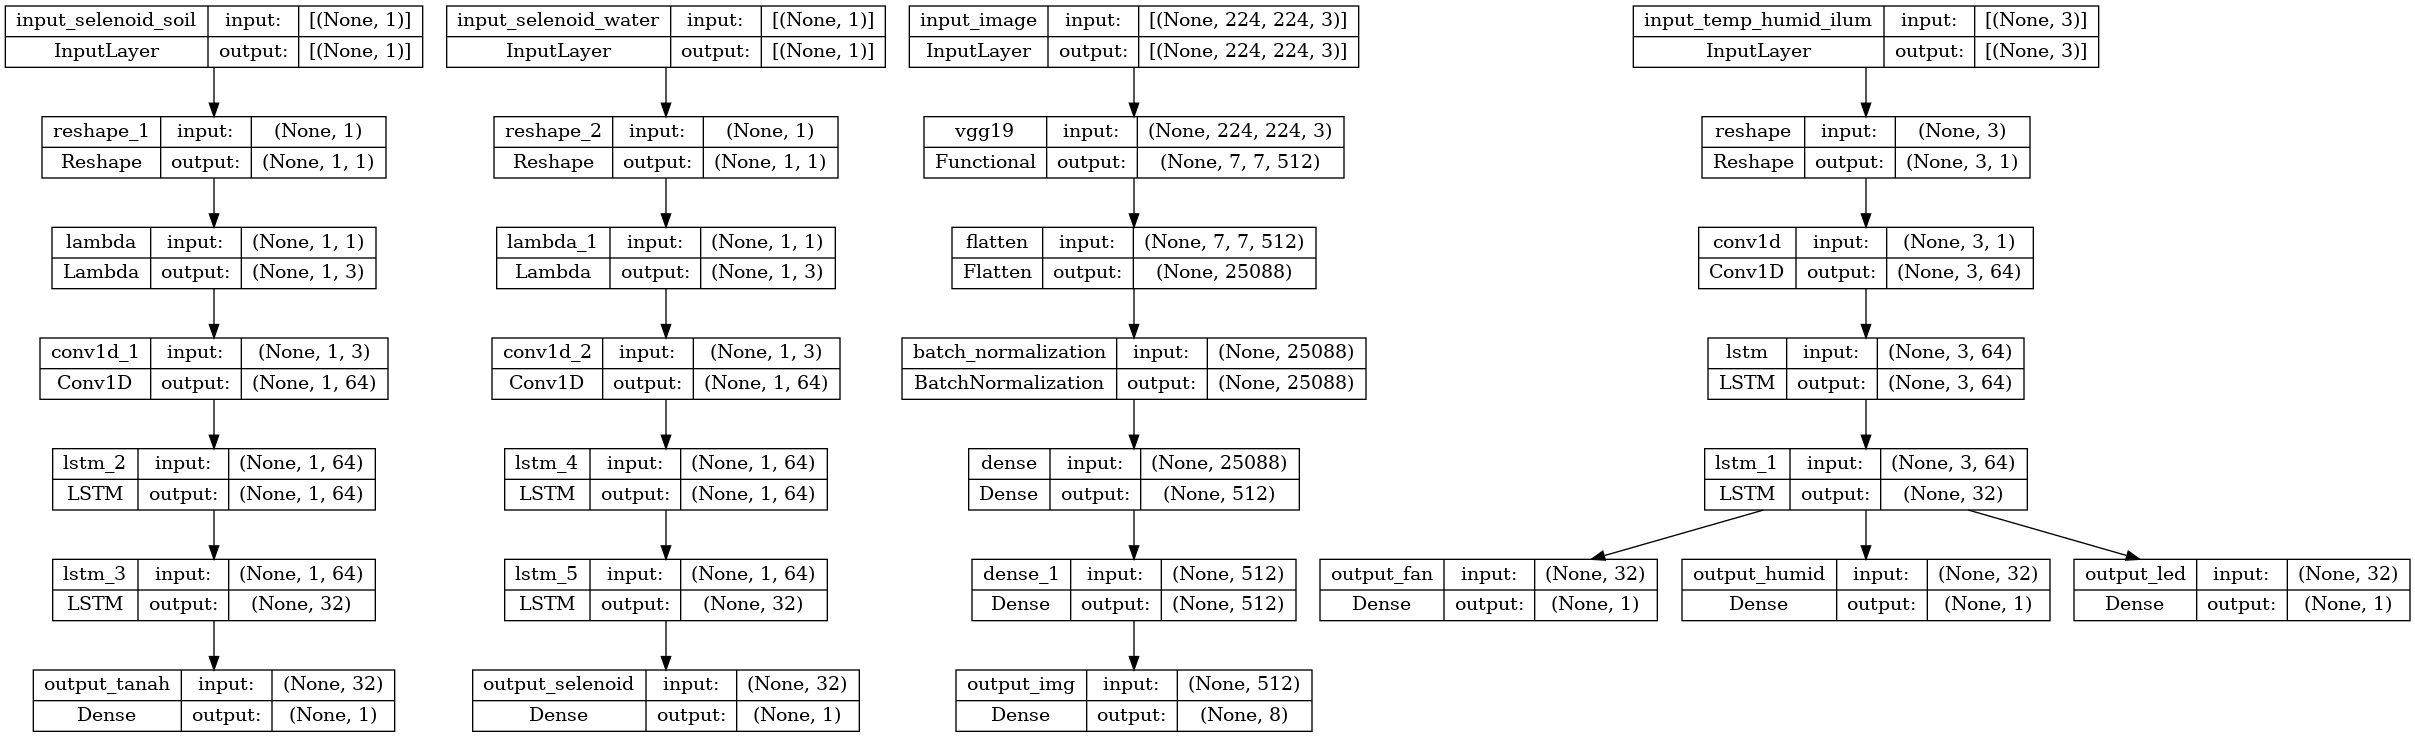

In [ ]:
model = tf.keras.Model(inputs=[input1, input2, input3, input4], outputs=[output_fan, output_humid, output_led, output_tanah, output_selenoid, output_img])
model.summary()
tf.keras.utils.plot_model(model, show_shapes=True, show_layer_names=True)

In [ ]:
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.0001,
    decay_steps=10000,
    decay_rate=0.9
)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

model.compile(optimizer=optimizer,
               loss={'output_fan': 'binary_crossentropy',
                    'output_humid': 'binary_crossentropy',
                    'output_led': 'binary_crossentropy',
                    'output_tanah': 'binary_crossentropy',
                    'output_selenoid': 'binary_crossentropy',
                    'output_img': 'sparse_categorical_crossentropy'},
              metrics={'output_fan': ['accuracy'],
                        'output_humid': ['accuracy'],
                        'output_led': ['accuracy'],
                        'output_tanah': ['accuracy'],
                        'output_selenoid': ['accuracy'],
                        'output_img': ['accuracy']}
               )

In [ ]:
print(len(train['PhTanah']))
print(len(train_images))
print()

print(len(val['PhTanah']))
print(len(val_images))
print()

print(len(test['PhTanah']))
print(len(test_images))
print()

5319
5323

1773
1770

1774
1770



## Butuh Penyelarasan

- train img : 5319
- val num : 1770
- test num jadi : 1770

In [ ]:
train_images = train_images[:5319]
train_labels = train_labels[:5319]

y_train_fan = y_train_fan[:5319]
y_train_humid = y_train_humid[:5319]
y_train_led = y_train_led[:5319]
y_train_tanah = y_train_tanah[:5319]
y_train_selenoid = y_train_selenoid[:5319]

val = val.iloc[:1770]
y_val_fan = y_val_fan[:1770]
y_val_humid = y_val_humid[:1770]
y_val_led = y_val_led[:1770]
y_val_tanah = y_val_tanah[:1770]
y_val_selenoid = y_val_selenoid[:1770]

test = test.iloc[:1770]
y_test_fan = y_test_fan[:1770]
y_test_humid = y_test_humid[:1770]
y_test_led = y_test_led[:1770]
y_test_tanah = y_test_tanah[:1770]
y_test_selenoid = y_test_selenoid[:1770]

In [ ]:
with tf.device('/device:GPU:0'):
    H = model.fit(
        x={'input_temp_humid_ilum': train[['Temperature', 'Humidity', 'Illumination']].values,
           'input_selenoid_soil': train[['PhTanah']].values,
           'input_selenoid_water': train[['Water_Level']].values,
           'input_image': train_images},
        y={'output_fan': y_train_fan,
           'output_humid': y_train_humid,
           'output_led': y_train_led,
           'output_tanah': y_train_tanah,
           'output_selenoid': y_train_selenoid,
           'output_img': train_labels},
        validation_data=(
            {'input_temp_humid_ilum': val[['Temperature', 'Humidity', 'Illumination']],
             'input_selenoid_soil': val[['PhTanah']],
             'input_selenoid_water': val[['Water_Level']],
             'input_image': val_images},
            {'output_fan': y_val_fan,
             'output_humid': y_val_humid,
             'output_led': y_val_led,
             'output_tanah': y_val_tanah,
             'output_selenoid': y_val_selenoid,
             'output_img': val_labels}),
        epochs=100,
        batch_size=32)

Epoch 1/100
167/167 [==============================] - 11s 67ms/step - loss: 3.2163 - output_fan_loss: 0.6743 - output_humid_loss: 0.6645 - output_led_loss: 0.6758 - output_tanah_loss: 0.4951 - output_selenoid_loss: 0.6538 - output_img_loss: 0.0528 - output_fan_accuracy: 0.5642 - output_humid_accuracy: 0.6022 - output_led_accuracy: 0.5907 - output_tanah_accuracy: 0.9487 - output_selenoid_accuracy: 0.6394 - output_img_accuracy: 0.9750 - val_loss: 3.0395 - val_output_fan_loss: 0.6384 - val_output_humid_loss: 0.6006 - val_output_led_loss: 0.6284 - val_output_tanah_loss: 0.4211 - val_output_selenoid_loss: 0.6529 - val_output_img_loss: 0.0981 - val_output_fan_accuracy: 0.6751 - val_output_humid_accuracy: 0.7390 - val_output_led_accuracy: 0.7328 - val_output_tanah_accuracy: 0.9045 - val_output_selenoid_accuracy: 0.6407 - val_output_img_accuracy: 0.9599
Epoch 2/100
167/167 [==============================] - 8s 46ms/step - loss: 3.0559 - output_fan_loss: 0.6626 - output_humid_loss: 0.6559 - ou

In [ ]:
results = model.evaluate(
    x={'input_temp_humid_ilum': test[['Temperature', 'Humidity', 'Illumination']].values,
       'input_selenoid_soil': test[['PhTanah']].values,
       'input_selenoid_water': test[['Water_Level']].values,
       'input_image': test_images},
    y={'output_fan': y_test_fan,
       'output_humid': y_test_humid,
       'output_led': y_test_led,
       'output_tanah': y_test_tanah,
       'output_selenoid': y_test_selenoid,
       'output_img': test_labels}
)

total_loss, loss_fan, loss_humid, loss_led, loss_tanah, loss_selenoid, loss_img, accuracy_fan, accuracy_humid, accuracy_led, accuracy_tanah, accuracy_selenoid, accuracy_img = results

print(f"Total Loss: {total_loss}")
print(f"Loss for Fan: {loss_fan}")
print(f"Loss for Humid: {loss_humid}")
print(f"Loss for LED: {loss_led}")
print(f"Loss for Selenoid: {loss_selenoid}")
print(f"Loss for Tanah: {loss_tanah}")

print("")

print(f"Accuracy for Fan: {accuracy_fan}")
print(f"Accuracy for Humid: {accuracy_humid}")
print(f"Accuracy for LED: {accuracy_led}")
print(f"Accuracy for Selenoid: {accuracy_selenoid}")
print(f"Accuracy for Tanah: {accuracy_tanah}")


56/56 [==============================] - 2s 32ms/step - loss: 1.1315 - output_fan_loss: 0.0062 - output_humid_loss: 0.0290 - output_led_loss: 0.0072 - output_tanah_loss: 0.0261 - output_selenoid_loss: 0.6588 - output_img_loss: 0.4043 - output_fan_accuracy: 0.9972 - output_humid_accuracy: 0.9825 - output_led_accuracy: 1.0000 - output_tanah_accuracy: 0.9893 - output_selenoid_accuracy: 0.6305 - output_img_accuracy: 0.9531
Total Loss: 1.1315306425094604
Loss for Fan: 0.006176729220896959
Loss for Humid: 0.028959276154637337
Loss for LED: 0.007215533405542374
Loss for Selenoid: 0.6588298082351685
Loss for Tanah: 0.026050109416246414

Accuracy for Fan: 0.9971751570701599
Accuracy for Humid: 0.9824858903884888
Accuracy for LED: 1.0
Accuracy for Selenoid: 0.6305084824562073
Accuracy for Tanah: 0.9892655611038208


In [ ]:
predictions = model.predict(
    x={'input_temp_humid_ilum': test[['Temperature', 'Humidity', 'Illumination']].values,
       'input_selenoid_soil': test[['PhTanah']].values,
       'input_selenoid_water': test[['Water_Level']].values,
       'input_image': test_images}
)

56/56 [==============================] - 4s 28ms/step


In [ ]:
predictions_fan = (predictions[0] > .4).astype(int)
predictions_humid = (predictions[1] > .55).astype(int)
predictions_led = (predictions[2] > .75).astype(int)
predictions_tanah = (predictions[3] > .55).astype(int)
predictions_selenoid = (predictions[4] > .45).astype(int)

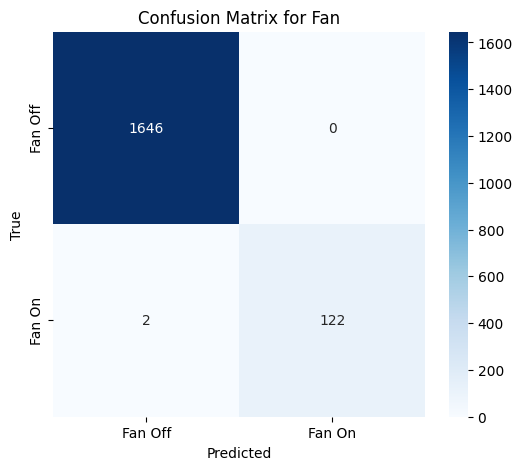

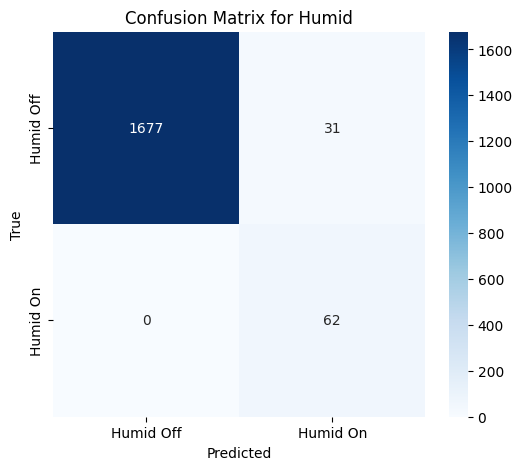

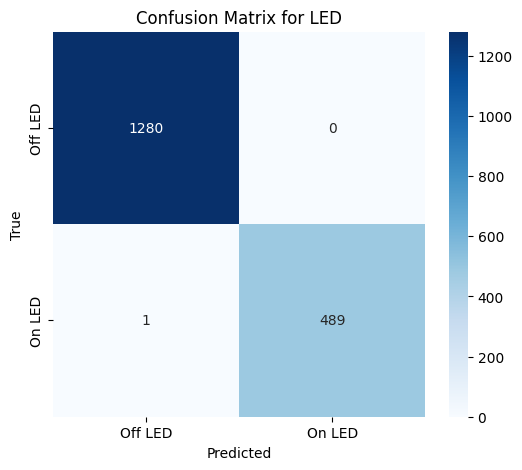

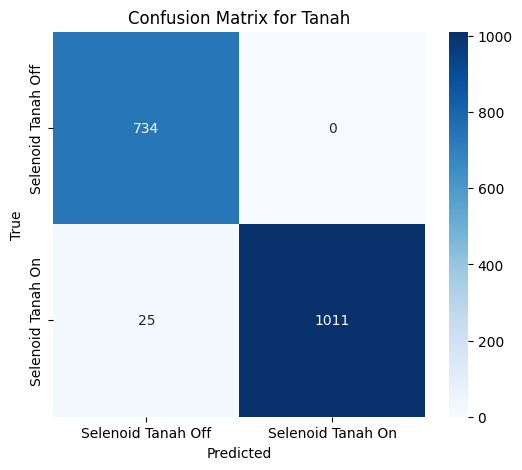

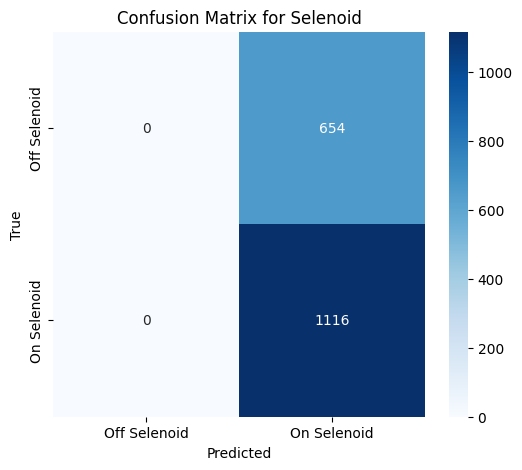

In [ ]:
cm_fan = confusion_matrix(y_test_fan, predictions_fan)
cm_humid = confusion_matrix(y_test_humid, predictions_humid)
cm_led = confusion_matrix(y_test_led, predictions_led)
cm_tanah = confusion_matrix(y_test_tanah, predictions_tanah)
cm_selenoid = confusion_matrix(y_test_selenoid, predictions_selenoid)

def plot_confusion_matrix(cm, labels, title):
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

plot_confusion_matrix(cm_fan, ['Fan Off', 'Fan On'], 'Confusion Matrix for Fan')
plot_confusion_matrix(cm_humid, ['Humid Off', 'Humid On'], 'Confusion Matrix for Humid')
plot_confusion_matrix(cm_led, ['Off LED', 'On LED'], 'Confusion Matrix for LED')
plot_confusion_matrix(cm_tanah, ['Selenoid Tanah Off', 'Selenoid Tanah On'], 'Confusion Matrix for Tanah')
plot_confusion_matrix(cm_selenoid, ['Off Selenoid', 'On Selenoid'], 'Confusion Matrix for Selenoid')


In [ ]:
report_fan = classification_report(y_test_fan, predictions_fan, target_names=['Off', 'On'])
report_humid = classification_report(y_test_humid, predictions_humid, target_names=['Low Humid', 'High Humid'])
report_led = classification_report(y_test_led, predictions_led, target_names=['Off', 'On'])
report_tanah = classification_report(y_test_tanah, predictions_tanah, target_names=['Low Tanah', 'High Tanah'])
report_selenoid = classification_report(y_test_selenoid, predictions_selenoid, target_names=['Off', 'On'])

print("Classification Report for Fan:")
print(report_fan)
print("\nClassification Report for Humid:")
print(report_humid)
print("\nClassification Report for LED:")
print(report_led)
print("\nClassification Report for Tanah:")
print(report_tanah)
print("\nClassification Report for Selenoid:")
print(report_selenoid)

Classification Report for Fan:
              precision    recall  f1-score   support

         Off       1.00      1.00      1.00      1646
          On       1.00      0.98      0.99       124

    accuracy                           1.00      1770
   macro avg       1.00      0.99      1.00      1770
weighted avg       1.00      1.00      1.00      1770


Classification Report for Humid:
              precision    recall  f1-score   support

   Low Humid       1.00      0.98      0.99      1708
  High Humid       0.67      1.00      0.80        62

    accuracy                           0.98      1770
   macro avg       0.83      0.99      0.90      1770
weighted avg       0.99      0.98      0.98      1770


Classification Report for LED:
              precision    recall  f1-score   support

         Off       1.00      1.00      1.00      1280
          On       1.00      1.00      1.00       490

    accuracy                           1.00      1770
   macro avg       1.00      1.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



In [ ]:
img_pred_classes = np.argmax(predictions[5], axis=1)
cm_img = confusion_matrix(img_pred_classes, data_test.labels)

([<matplotlib.axis.YTick at 0x7f26d866c340>,
 [Text(0, 0, 'day 1'),
  Text(0, 1, 'day 2'),
  Text(0, 2, 'day 3'),
  Text(0, 3, 'day 4'),
  Text(0, 4, 'day 5'),
  Text(0, 5, 'day 6'),
  Text(0, 6, 'day 7'),
  Text(0, 7, 'day 8')])

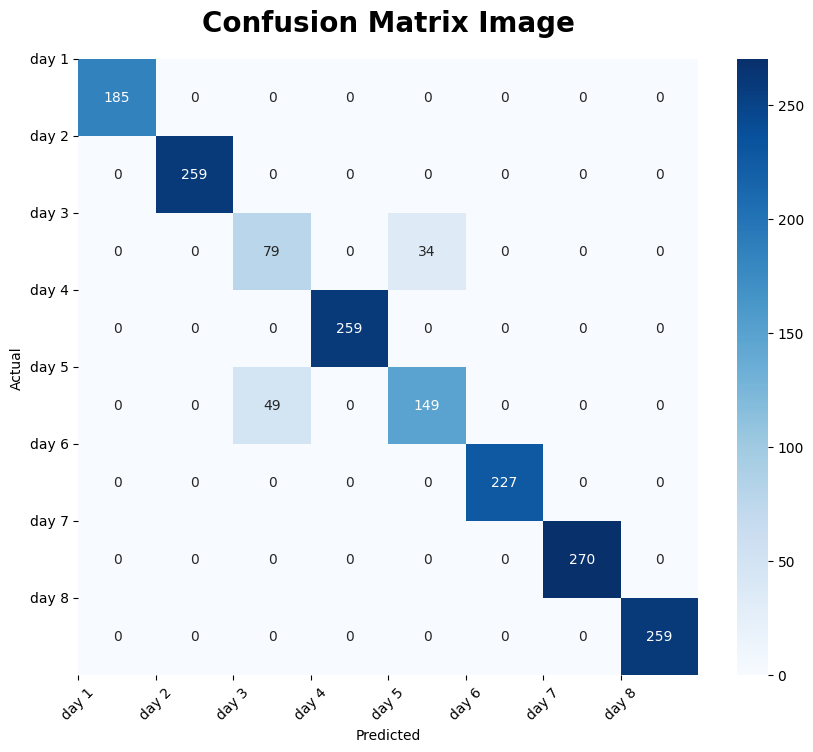

In [ ]:
plt.figure(figsize=(10, 8))  # Set the figure size if needed
sns.heatmap(cm_img, annot=True, cmap='Blues', fmt='g')

plt.title('Confusion Matrix Image', pad=20, fontsize=20, fontweight="bold")
plt.ylabel('Actual')
plt.xlabel('Predicted')

# Set ticks for the x and y axes using class names
plt.xticks(ticks=range(len(classes)), labels=classes, rotation=45)
plt.yticks(ticks=range(len(classes)), labels=classes, rotation=0)